## Handling datasets with multiple modalities

In [1]:
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

import scarf
scarf.__version__

'0.8.2'

time: 2.28 s


---
### 1) Fetch and convert data

For this tutorial we will use CITE-Seq data from 10x genomics. This dataset contains two modalities: gene expression and surface protein abundance. Throughout this tutorial we will refer to gene expression modality as `RNA` and surface protein as `ADT`. We start by downloading the data and converting it into Zarr format:

In [2]:
scarf.fetch_dataset('tenx_8K_pbmc_citeseq', save_path='scarf_datasets')

INFO: Download started...
INFO: Download finished! File saved here: C:\Users\parashar\Desktop\scarf\docs\source\vignettes\scarf_datasets\tenx_8K_pbmc_citeseq\data.h5
time: 16.9 s


In [3]:
reader = scarf.CrH5Reader('scarf_datasets/tenx_8K_pbmc_citeseq/data.h5', 'rna')

time: 94 ms


We can also quickly check the different kinds of assays present in the file and the number of features from each of them.

In [4]:
reader.assayFeats

RNA            assay2
type       Gene Expression  Antibody Capture
start                    0             33538
end                  33538             33555
nFeatures            33538                17

time: 16 ms


The **nFeatures** column shows the number of features present in each assay. `CrH5Reader` will automatically pull this information from H5 file and rename the 'Gene Expression' assay to **RNA**. Here it also found another assay: 'Antibody Capture' and named it to **assay2**. We will rename this to **ADT**.

In [5]:
reader.rename_assays({'assay2': 'ADT'})
reader.assayFeats

RNA               ADT
type       Gene Expression  Antibody Capture
start                    0             33538
end                  33538             33555
nFeatures            33538                17

time: 16 ms


Now the data is converted into Zarr format. Like single assay datasets, all the data is saved under one Zarr file.

In [6]:
writer = scarf.CrToZarr(reader, zarr_fn='scarf_datasets/tenx_8K_pbmc_citeseq/data.zarr',
                        chunk_size=(2000, 1000))
writer.dump(batch_size=1000)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.12it/s]

time: 7.55 s


---
### 2) Create a multimodal DataStore

The next step is to create a Scarf `DataStore` object. This object will be the primary way to interact with the data and all its constituent assays. The first time a Zarr file is loaded, we need to set the default assay. Here we set the 'RNA' assay as the default assay. When a Zarr file is loaded, Scarf checks if some per-cell statistics have been calculated. If not, then **nFeatures** (number of features per cell) and **nCounts** (total sum of feature counts per cell) are calculated. Scarf will also attempt to calculate the percent of mitochondrial and ribosomal content per cell.

In [7]:
ds = scarf.DataStore('scarf_datasets/tenx_8K_pbmc_citeseq/data.zarr',
                     default_assay='RNA',
                     nthreads=4)

INFO: Setting assay ADT to assay type: ADTassay
INFO: (ADT) Computing nCells and dropOuts
[########################################] | 100% Completed |  0.1s
INFO: Setting assay RNA to assay type: RNAassay
INFO: (RNA) Computing nCells and dropOuts
[########################################] | 100% Completed |  1.7s
INFO: (ADT) Computing nCounts
[########################################] | 100% Completed |  0.1s
INFO: (ADT) Computing nFeatures
[########################################] | 100% Completed |  0.1s
INFO: (RNA) Computing nCounts
[########################################] | 100% Completed |  1.1s
INFO: (RNA) Computing nFeatures
[########################################] | 100% Completed |  1.4s
INFO: Computing percentage of RNA_percentMito
[########################################] | 100% Completed |  1.4s
INFO: Computing percentage of RNA_percentRibo
[########################################] | 100% Completed |  1.4s
time: 8.77 s


We can print out the DataStore object to get an overview of all the assays stored.

In [8]:
ds

DataStore has 7865 (7865) cells with 2 assays: ADT RNA
   Cell metadata:
            'I', 'ids', 'names', 'ADT_nCounts', 'ADT_nFeatures', 
            'RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito', 'RNA_percentRibo'
   ADT assay has 17 (17) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          
   RNA assay has 13832 (33538) features and following metadata:
            'I', 'ids', 'names', 'dropOuts', 'nCells', 
          

time: 47 ms


Feature attribute tables for each of the assays can be accessed like this:

In [9]:
ds.RNA.feats.head()

I              ids        names  dropOuts  nCells
0  False  ENSG00000243485  MIR1302-2HG      7865       0
1  False  ENSG00000237613      FAM138A      7865       0
2  False  ENSG00000186092        OR4F5      7865       0
3  False  ENSG00000238009   AL627309.1      7853      12
4  False  ENSG00000239945   AL627309.3      7865       0

time: 47 ms


In [10]:
ds.ADT.feats.head()

I   ids           names  dropOuts  nCells
0  True   CD3   CD3_TotalSeqB         1    7864
1  True   CD4   CD4_TotalSeqB         1    7864
2  True  CD8a  CD8a_TotalSeqB         2    7863
3  True  CD14  CD14_TotalSeqB         1    7864
4  True  CD15  CD15_TotalSeqB         1    7864

time: 47 ms


Cell filtering is performed based on the default assay. Here we use the `auto_filter_cells` method of the `DataStore` to filter low quality cells.

INFO: 154 cells flagged for filtering out using attribute RNA_nCounts
INFO: 326 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 119 cells flagged for filtering out using attribute RNA_percentMito
INFO: 21 cells flagged for filtering out using attribute RNA_percentRibo


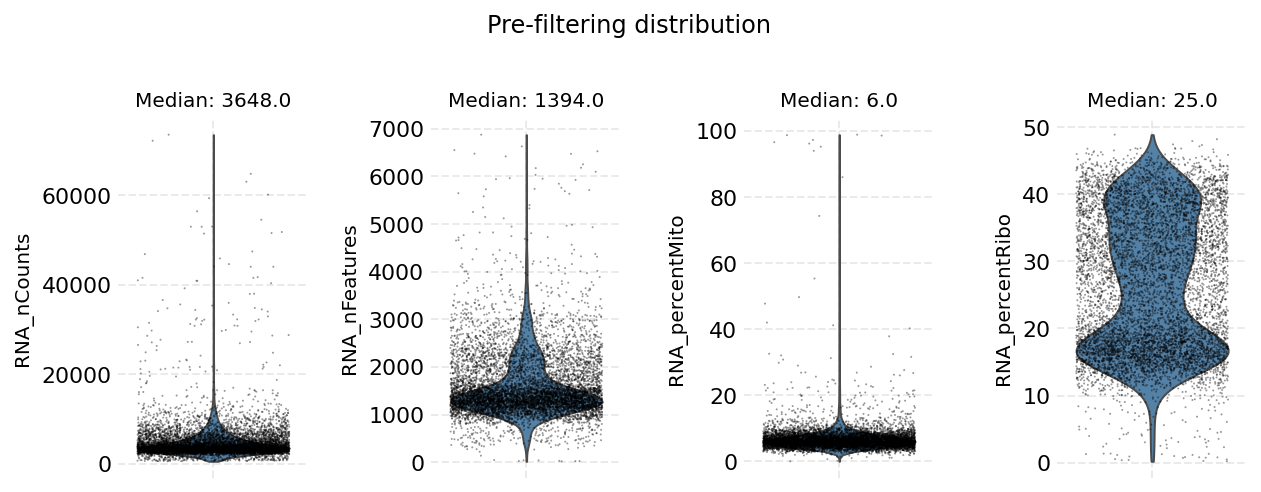

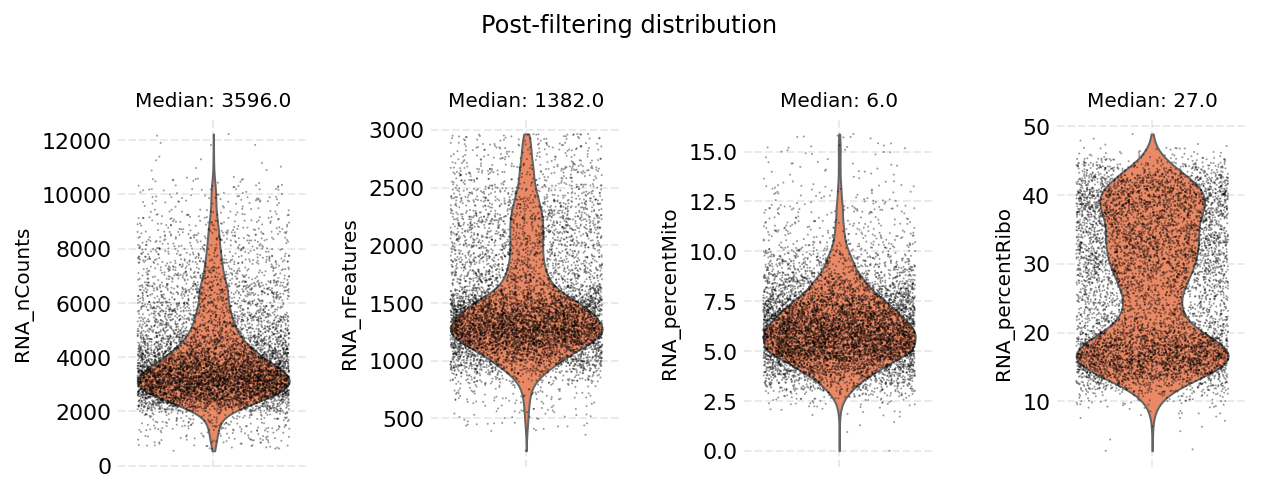

time: 5.89 s


In [11]:
ds.auto_filter_cells()

---
### 3) Process gene expression modality

Now we process the RNA assay to perform feature selection, create KNN graph, run UMAP reduction and clustering. These steps are same as shown in the basic workflow for scRNA-Seq data.

INFO: (RNA) Computing nCells
[########################################] | 100% Completed |  2.1s
INFO: (RNA) Computing normed_tot
[########################################] | 100% Completed |  1.9s
INFO: (RNA) Computing sigmas
[########################################] | 100% Completed |  2.9s
INFO: 497 genes marked as HVGs


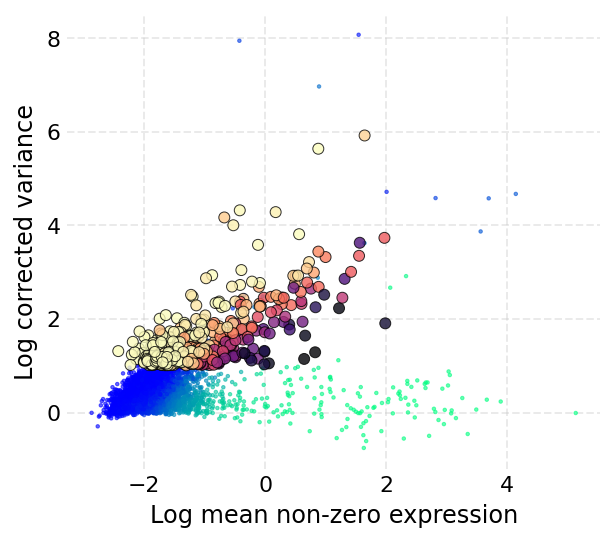

INFO: No value provided for parameter `log_transform`. Will use default value: True
INFO: No value provided for parameter `renormalize_subset`. Will use default value: True
INFO: No value provided for parameter `pca_cell_key`. Will use default value: I
INFO: Using PCA for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5
INFO: Normalizing with feature subset
[########################################] | 100% Completed |  1.0s


Writing data to normed__I__hvgs/data: 100%|██████████████████████████████████████████████| 4/4 [00:01<00:00,  3.48it/s]

INFO: Calculating mean of norm. data
[######################                  ] | 55% Completed |  0.1s

[########################################] | 100% Completed |  0.2s
INFO: Calculating std. dev. of norm. data
[########################################] | 100% Completed |  0.2s


Estimating seed partitions: 100%|████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]

INFO: Saving loadings to RNA/normed__I__hvgs/reduction__pca__15__I
INFO: Saving ANN index to RNA/normed__I__hvgs/reduction__pca__15__I/ann__l2__50__50__48__4466


INFO: Saving kmeans clusters to RNA/normed__I__hvgs/reduction__pca__15__I/kmeans__100__4466


Saving KNN graph: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]

INFO: ANN recall: 99.78%



Smoothening KNN distances: 100%|█████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]
C:\Users\parashar\miniconda3\envs\scarf\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 33.8 s


In [12]:
ds.mark_hvgs(min_cells=20, top_n=500, min_mean=-3, max_mean=2, max_var=6)
ds.make_graph(feat_key='hvgs', k=11, dims=15, n_centroids=100)
ds.run_umap(fit_n_epochs=250, spread=5, min_dist=1, parallel=True)
ds.run_leiden_clustering(resolution=1)

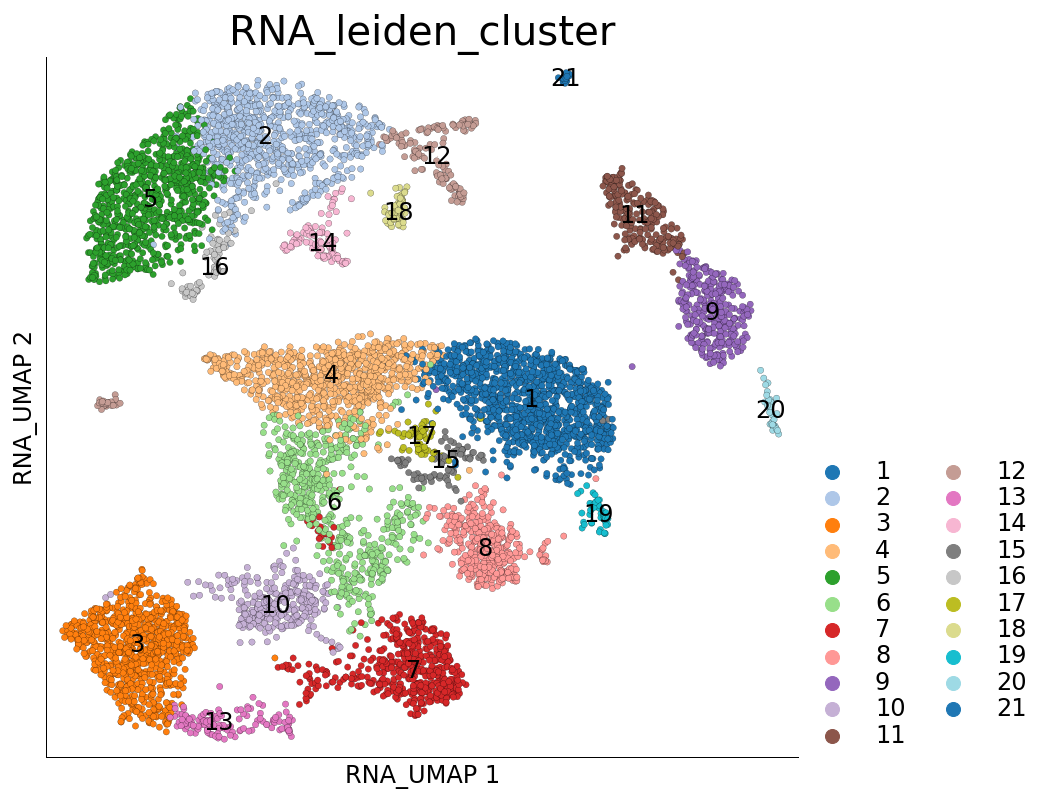

time: 1.06 s


In [13]:
ds.plot_layout(layout_key='RNA_UMAP', color_by='RNA_leiden_cluster')

---
### 4) Process protein surface abundance modality

We will now perform similar steps as RNA for the ADT data. Since ADT panels are often custom designed, we will not perform any feature selection step. This particular data contains some control antibodies which we should filter out before downstream analysis. 

In [14]:
ds.ADT.feats.head(n=ds.ADT.feats.N)

I     ids                    names  dropOuts  nCells
0   True     CD3            CD3_TotalSeqB         1    7864
1   True     CD4            CD4_TotalSeqB         1    7864
2   True    CD8a           CD8a_TotalSeqB         2    7863
3   True    CD14           CD14_TotalSeqB         1    7864
4   True    CD15           CD15_TotalSeqB         1    7864
5   True    CD16           CD16_TotalSeqB         1    7864
6   True    CD56           CD56_TotalSeqB         1    7864
7   True    CD19           CD19_TotalSeqB       163    7702
8   True    CD25           CD25_TotalSeqB         4    7861
9   True  CD45RA         CD45RA_TotalSeqB         1    7864
10  True  CD45RO         CD45RO_TotalSeqB         1    7864
11  True    PD-1           PD-1_TotalSeqB         2    7863
12  True   TIGIT          TIGIT_TotalSeqB        16    7849
13  True   CD127          CD127_TotalSeqB         3    7862
14  True   IgG2a  IgG2a_control_TotalSeqB        26    7839
15  True    IgG1   IgG1_control_TotalSeqB         9    7856
16  True   IgG2b  IgG2b_control_TotalSeqB       226    7639

time: 31 ms


We can manually filter out the control antibodies by updating **I** to be False for those features. To do so we first extract the names of all the ADT features like below:

In [15]:
adt_names = ds.ADT.feats.to_pandas_dataframe(['names'])['names']
adt_names

0               CD3_TotalSeqB
1               CD4_TotalSeqB
2              CD8a_TotalSeqB
3              CD14_TotalSeqB
4              CD15_TotalSeqB
5              CD16_TotalSeqB
6              CD56_TotalSeqB
7              CD19_TotalSeqB
8              CD25_TotalSeqB
9            CD45RA_TotalSeqB
10           CD45RO_TotalSeqB
11             PD-1_TotalSeqB
12            TIGIT_TotalSeqB
13            CD127_TotalSeqB
14    IgG2a_control_TotalSeqB
15     IgG1_control_TotalSeqB
16    IgG2b_control_TotalSeqB
Name: names, dtype: object

time: 15 ms


The ADT features with 'control' in name are designated as control antibodies. You can have your own selection criteria here. The aim here is to create a boolean array that has `True` value for features to be removed.

In [16]:
is_control = adt_names.str.contains('control').values
is_control

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True])

time: 0 ns


Now we update `I` to remove the control features. `update_key` method takes a boolean array and disables the features that have `False` value. So we invert the above created array (using `~`) before providing it to `update_key`. The second parameter for `update_key` denotes which feature table boolean column to modify, `I` in this case.

In [17]:
ds.ADT.feats.update_key(~is_control, 'I')
ds.ADT.feats.head(n=ds.ADT.feats.N)

I     ids                    names  dropOuts  nCells
0    True     CD3            CD3_TotalSeqB         1    7864
1    True     CD4            CD4_TotalSeqB         1    7864
2    True    CD8a           CD8a_TotalSeqB         2    7863
3    True    CD14           CD14_TotalSeqB         1    7864
4    True    CD15           CD15_TotalSeqB         1    7864
5    True    CD16           CD16_TotalSeqB         1    7864
6    True    CD56           CD56_TotalSeqB         1    7864
7    True    CD19           CD19_TotalSeqB       163    7702
8    True    CD25           CD25_TotalSeqB         4    7861
9    True  CD45RA         CD45RA_TotalSeqB         1    7864
10   True  CD45RO         CD45RO_TotalSeqB         1    7864
11   True    PD-1           PD-1_TotalSeqB         2    7863
12   True   TIGIT          TIGIT_TotalSeqB        16    7849
13   True   CD127          CD127_TotalSeqB         3    7862
14  False   IgG2a  IgG2a_control_TotalSeqB        26    7839
15  False    IgG1   IgG1_control_TotalSeqB         9    7856
16  False   IgG2b  IgG2b_control_TotalSeqB       226    7639

time: 31 ms


Assays named ADT are automatically created as objects of the `ADTassay` class, which uses CLR (centred log ratio) normalization as the default normalization method.

In [18]:
print (ds.ADT)
print (ds.ADT.normMethod.__name__)

ADTassay ADT with 14(17) features
norm_clr
time: 15 ms


Now we are ready to create a KNN graph of cells using only ADT data. Here we will use all the features (except those that were filtered out) and that is why we use `I` as value for `feat_key`. It is important to note the value for `from_assay` parameter which has now been set to `ADT`. If no value is provided for `from_assay` then it is automatically set to the default assay. 

In [19]:
ds.make_graph(from_assay='ADT', feat_key='I', k=11, dims=11, n_centroids=100)

INFO: No value provided for parameter `log_transform`. Will use default value: True
INFO: No value provided for parameter `renormalize_subset`. Will use default value: True
INFO: No value provided for parameter `pca_cell_key`. Will use default value: I
INFO: Using PCA for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5


Writing data to normed__I__I/data: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.62it/s]

INFO: Calculating mean of norm. data


[########################################] | 100% Completed |  0.1s
INFO: Calculating std. dev. of norm. data
[########################################] | 100% Completed |  0.1s


Estimating seed partitions: 100%|████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.29it/s]

INFO: Saving loadings to ADT/normed__I__I/reduction__pca__11__I


INFO: Saving ANN index to ADT/normed__I__I/reduction__pca__11__I/ann__l2__50__50__48__4466
INFO: Saving kmeans clusters to ADT/normed__I__I/reduction__pca__11__I/kmeans__100__4466


Saving KNN graph: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]

INFO: ANN recall: 99.96%



Smoothening KNN distances: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.62it/s]

time: 2.92 s


UMAP and clustering can be run on ADT assay by simply setting `from_assay` parameter value to 'ADT':

In [20]:
ds.run_umap(from_assay='ADT', fit_n_epochs=250, spread=5, min_dist=1, parallel=True)
ds.run_leiden_clustering(from_assay='ADT', resolution=1)

C:\Users\parashar\miniconda3\envs\scarf\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 11 s


If we now check the cell attribute table, we will find the UMAP coordinates and clusters calculated using `ADT` assay:

In [21]:
ds.cells.head()

I                 ids               names  ADT_UMAP1  ADT_UMAP2  \
0  True  AAACCCAAGATTGTGA-1  AAACCCAAGATTGTGA-1 -24.960340  17.237595   
1  True  AAACCCACATCGGTTA-1  AAACCCACATCGGTTA-1 -10.811583  21.625820   
2  True  AAACCCAGTACCGCGT-1  AAACCCAGTACCGCGT-1 -14.716150  23.468601   
3  True  AAACCCAGTATCGAAA-1  AAACCCAGTATCGAAA-1  24.684650  16.921862   
4  True  AAACCCAGTCGTCATA-1  AAACCCAGTCGTCATA-1  27.789581  17.818371   

   ADT_leiden_cluster  ADT_nCounts  ADT_nFeatures  RNA_UMAP1  RNA_UMAP2  \
0                   7        981.0           17.0 -26.757975  22.886894   
1                  14       1475.0           17.0 -24.371563  19.545330   
2                   7       7149.0           17.0 -17.020401  22.427437   
3                   3       6831.0           17.0 -24.521263 -20.203983   
4                   3       6839.0           17.0 -22.969336 -30.734549   

   RNA_leiden_cluster  RNA_nCounts  RNA_nFeatures  RNA_percentMito  \
0                   5       6160.0         2194.0         8.668831   
1                   5       6713.0         2093.0         6.316103   
2                   5       3637.0         1518.0         8.056090   
3                   3       1244.0          737.0         9.003215   
4                   3       2611.0         1240.0         6.204519   

   RNA_percentRibo  
0        15.259740  
1        19.037688  
2        16.002200  
3        18.729904  
4        16.353887

time: 63 ms


Visualizing the UMAP and clustering calcualted using `ADT` only:

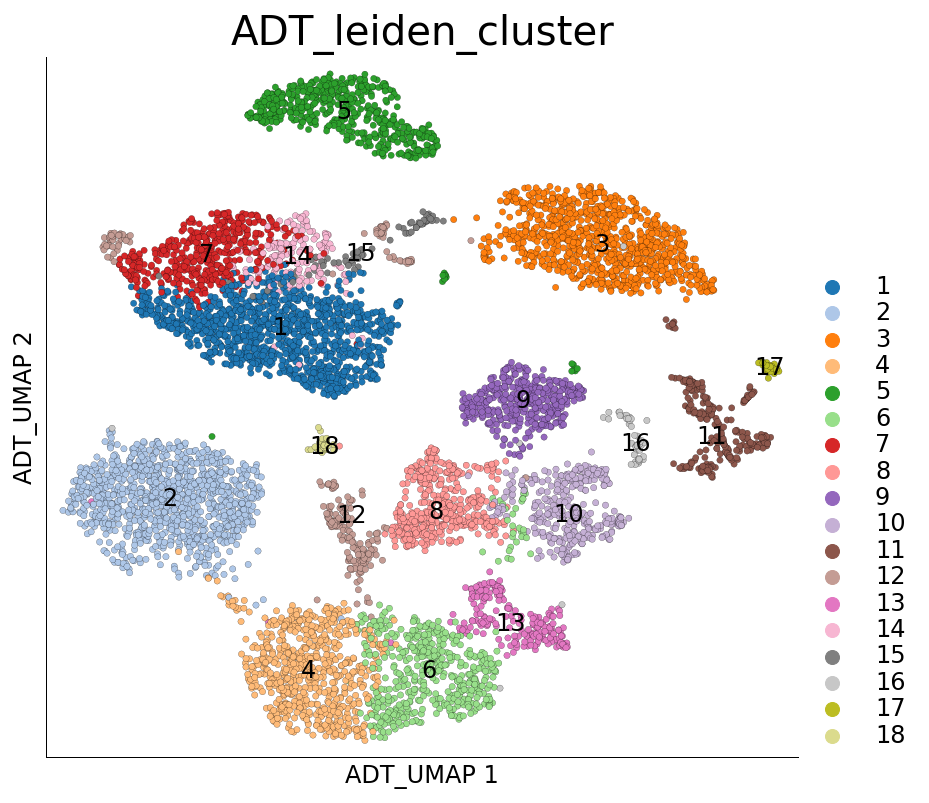

time: 938 ms


In [22]:
ds.plot_layout(layout_key='ADT_UMAP', color_by='ADT_leiden_cluster')

---
### 5) Cross modality comparison

It is generally of interest to see how different modalities corroborate each other.

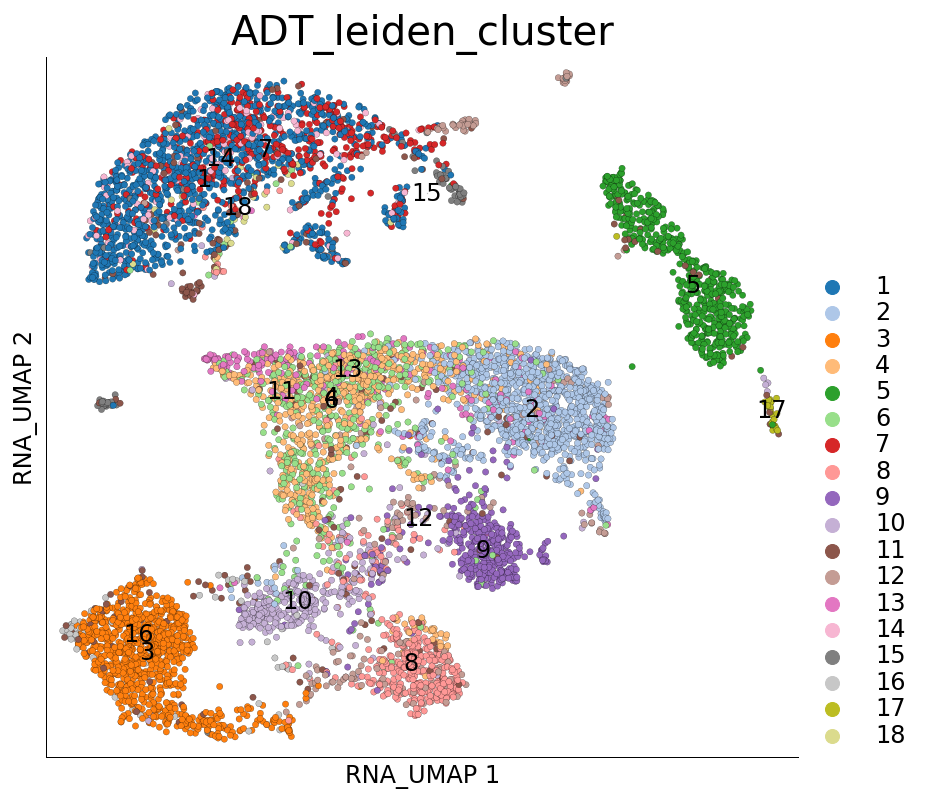

time: 890 ms


In [23]:
# UMAP on RNA and coloured with clusters calculated on ADT
ds.plot_layout(layout_key='RNA_UMAP', color_by='ADT_leiden_cluster')

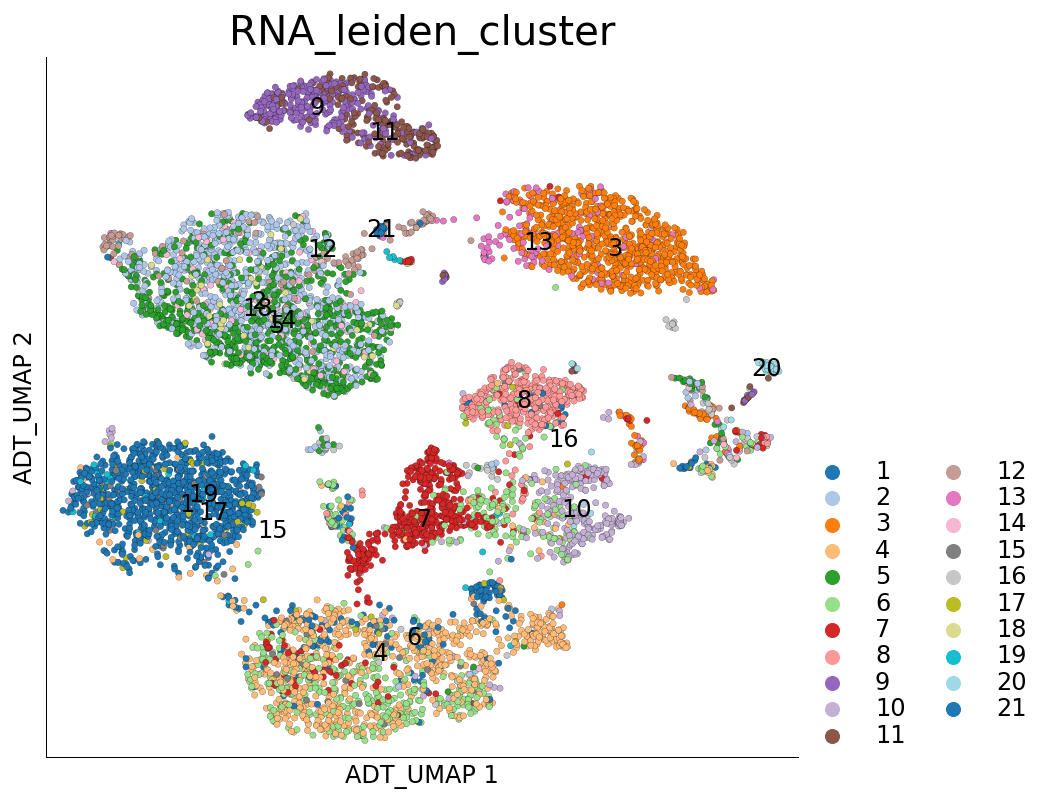

time: 1.09 s


In [24]:
# UMAP on ADT and coloured with clusters calculated on RNA
ds.plot_layout(layout_key='ADT_UMAP', color_by='RNA_leiden_cluster')

We can quantify the overlap of cells between RNA and ADT clusters. The following table has ADT clusters on columns and RNA clusters on rows. This table shows a cross tabulation of cells across the clustering from the two modalities.

In [25]:
import pandas as pd

df = pd.crosstab(ds.cells.fetch('RNA_leiden_cluster'),
                 ds.cells.fetch('ADT_leiden_cluster'))
df

col_0   1    2    3    4    5    6    7    8    9    10  11  12   13  14  15  \
row_0                                                                          
1        0  919    0   63    1   40    0    0   15    1  16  19   62   0   0   
2      441    0    0    0    0    4  266    3    0    1  20   2    1  72   3   
3        0    0  743    0    0    0    0    0    0    3  30   0    0   0   0   
4        0   20    0  349    0  245    0    3    1   10  21   8  133   0   0   
5      564    0    0    0    0    2   96    2    0    1  24   2    1  63   6   
6        0    4    1  166    0  145    0   59   42   74  24  44    3   0   0   
7        0    0    4   45    0   10    0  325    5    6  16  87    0   0   0   
8        0    0    0    0    0    7    0    5  335    7   5   9    1   0   0   
9        0    0    0    0  319    0    0    0    0    0   8   0    0   0   0   
10       0   15    2    2    0   16    0    6    3  225  19   3    2   0   0   
11       0    0    0    0  203    1    0    0    0    0  11   2    0   0   0   
12      17    0    0    0    1    0   29    0    0    0  11  32    0   1  67   
13       0    0  123    0    0    0    0    1    0    0   3   2    0   0   2   
14      59    0    0    0    0    1   19    1    0    0   8   1    0   5   2   
15       0   40    0   17    0   12    0    0    4    0   2   3    3   0   0   
16      12    0    1    1    0    4    0   13    0    2  36   0    1   1   0   
17       0   45    1    4    0    3    0    0    6    1   1   1    5   0   0   
18      33    0    0    0    0    0   13    0    0    0   1   0    0   8   0   
19       0   31    0    1    0    1    0    0    0    2   0  11    3   0   0   
20       0    0    0    0    2    0    0    0    0    4   5   0    0   0   0   
21       0    0    0    0    0    0    0    0    0    0   0  21    0   0   1   

col_0  16  17  18  
row_0              
1       0   0   0  
2       0   0  14  
3      31   0   0  
4       0   0   0  
5       0   0   7  
6       1   0   0  
7       6   0   0  
8       0   0   0  
9       0   0   0  
10     14   0   0  
11      0   1   0  
12      0   0   0  
13      5   0   0  
14      0   0   1  
15      0   0   0  
16      0   0   6  
17      0   0   0  
18      0   0   1  
19      0   0   0  
20      0  29   0  
21      0   0   0

time: 63 ms


There are possibly many interesting strategies to analyze this further. One simple way to summarize the above table can be quantify the transcriptomics 'purity' of ADT clusters:

In [26]:
(100 * df.max()/df.sum()).sort_values(ascending=False)

col_0
17    96.666667
2     85.567970
3     84.914286
15    82.716049
9     81.508516
8     77.751196
10    66.765579
7     62.884161
13    61.860465
5     60.646388
16    54.385965
4     53.858025
1     50.088810
6     49.898167
18    48.275862
14    48.000000
12    35.222672
11    13.793103
dtype: float64

time: 0 ns


Individual ADT expression can be visualized in both UMAPs easily.

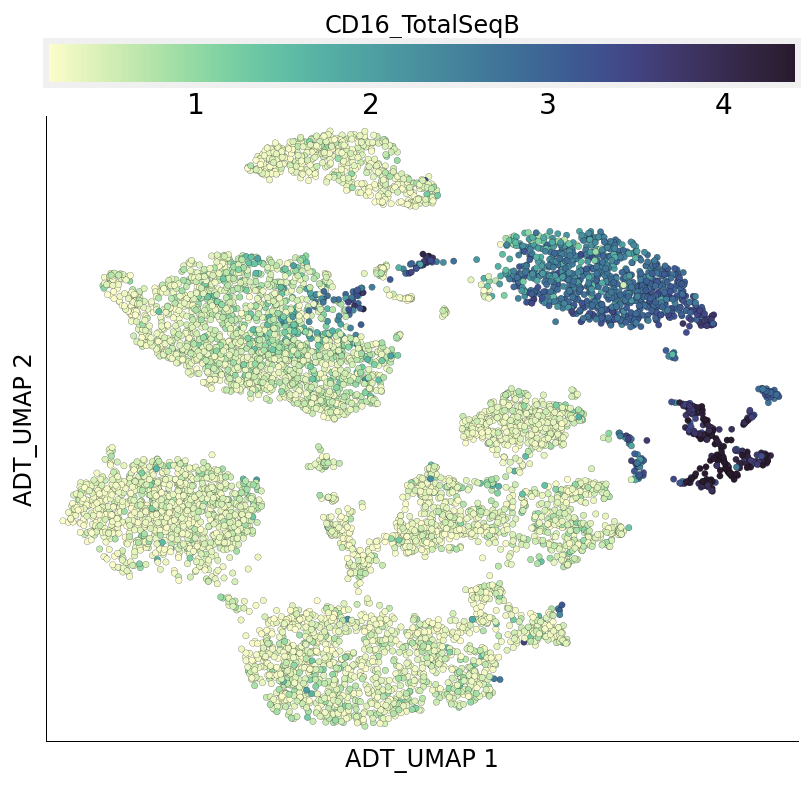

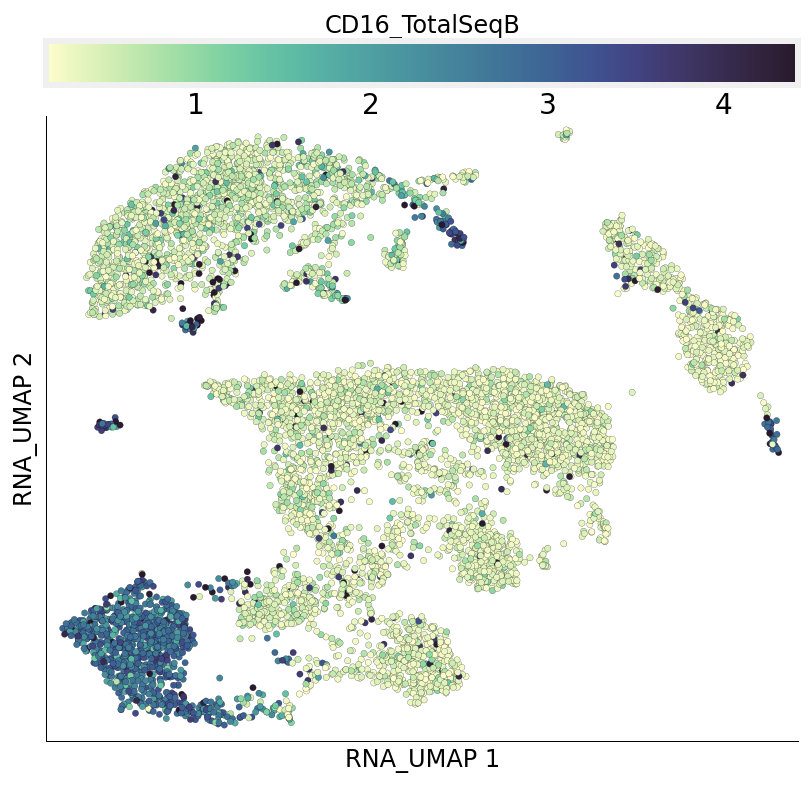

time: 1.62 s


In [27]:
ds.plot_layout(from_assay='ADT', layout_key='ADT_UMAP', color_by='CD16_TotalSeqB')
ds.plot_layout(from_assay='ADT', layout_key='RNA_UMAP', color_by='CD16_TotalSeqB')

We can also query gene expression and visualize it on both RNA and ADT UMAPs. Here we query gene FCGR3A which codes for CD16:

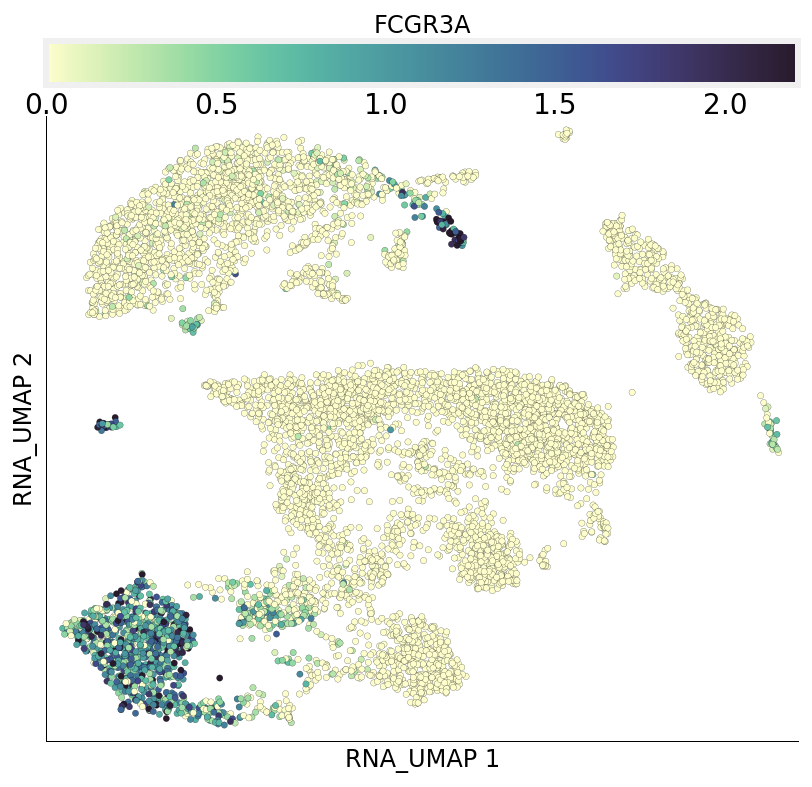

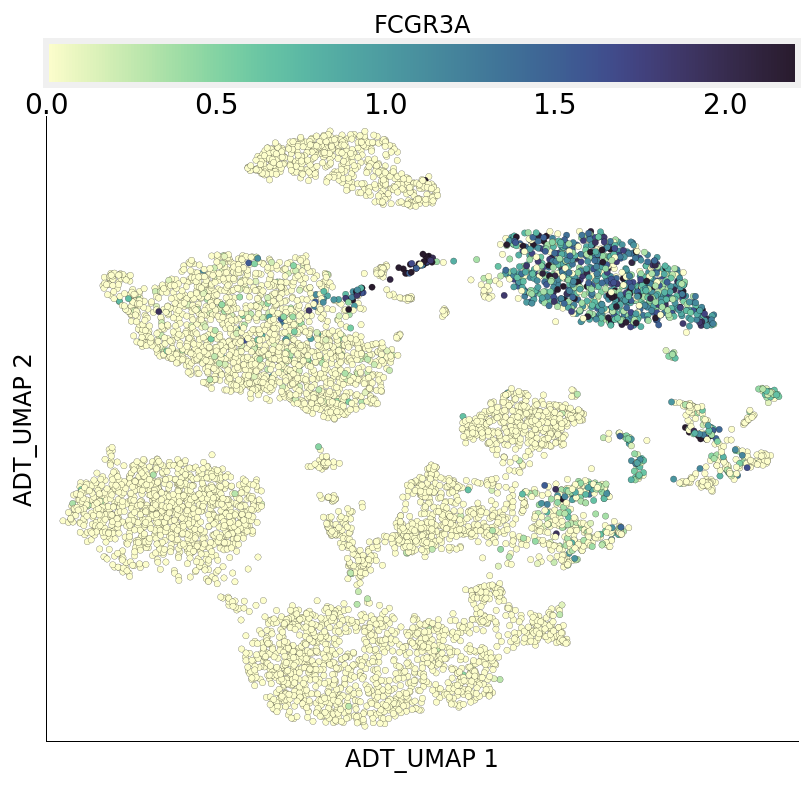

time: 1.89 s


In [28]:
ds.plot_layout(from_assay='RNA', layout_key='RNA_UMAP', color_by='FCGR3A')
ds.plot_layout(from_assay='RNA', layout_key='ADT_UMAP', color_by='FCGR3A')

---
That is all for this vignette.